In [3]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [4]:
from platform import python_version
print(python_version())

3.9.7


In [5]:
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
yperf=yperf["Perf"]

In [6]:
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", index_col=0)

In [7]:
X_train.shape

(16668, 18)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rfregressor = RandomForestRegressor(random_state=5, max_depth=10)

rfregressor.fit(X_train, y_train)
y_pred = rfregressor.predict(X_test)
from sklearn.metrics import mean_squared_error
print('train mse: ', mean_squared_error(y_train, rfregressor.predict(X_train)))
print('test mse: ', mean_squared_error(y_test, y_pred))


import pickle
pickle.dump(rfregressor, open("pl_rfregressor.p", "wb" ))

C:\Users\Usuario\AppData\Local\Temp/ipykernel_16312/3305220768.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfregressor.fit(X_train, y_train)


train mse:  0.49296521983495833
test mse:  1.2522921931471631


In [10]:
# X AND Y (no splitting for train/test)
# Financial ratios 
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
# annual stock performances
y=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", index_col=0)
# convert to date
y["Date"], y["Date2"]=pd.to_datetime(y["Date"]), pd.to_datetime(y["Date2"])

# X AND Y (splitting for train/test)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", index_col=0)

y_=pd.DataFrame()
y_=y.loc[y_test.index.values, :]

# convert string to datetime
y_["Date"], y_["Date2"]=pd.to_datetime(y_["Date"]), pd.to_datetime(y_["Date2"])

In [11]:
# Calculate Altman Z'' scores 1995
def calcZScores(x):
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * x['(CA-CL)/TA']\
    + 3.26 * x['RE/TA']\
    + 6.72 * x['EBIT/TA']\
    + 1.05 * x['Book Equity/TL']
    return Z

In [12]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData():
    daily_stock_prices=pd.read_csv('C:/Users/Usuario/MachineLearning/Stock_Data/SimFin/us-shareprices-daily/us-shareprices-daily.csv',\
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', daily_stock_prices.shape)
    return daily_stock_prices

In [13]:
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [14]:
def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
#     # Alternative way
#     rows = d[(d["Date"].between(pd.to_datetime(date1),\
#                                 pd.to_datetime(date2) )) \
#                                  & (d["Ticker"]==ticker)]
    rows = d.loc[(d["Date"].values>date1) &\
                 (d["Date"].values<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

In [15]:
def getStockPriceData(ticker, y_, mask, daily_stock_prices, rows):
    date1 = y_[mask][y_[mask]["Ticker"] == ticker]["Date"].values[0]
    date2 = y_[mask][y_[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

In [16]:
def getDataForDateRange(date_Index_New, rows):
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        WeeklyStockDataRows = WeeklyStockDataRows.append(\
          rows.iloc[rows.index.get_loc(I, method="nearest")])
    return WeeklyStockDataRows

In [17]:
def getStockTimeSeries(dateTimeIndex, y_, tickers, mask, daily_stock_prices):
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows=pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_, mask, daily_stock_prices, rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new, rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick]=WeeklyStockDataRows["Close"].values
    return stockRet

In [18]:
def getPortfolioRelativeTimeSeries(stockRet):
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

In [19]:
# Function returns to us dataframes of selected stocks/portfolio performance for 1 year.
# y_ is annual stock performances (all backtest years)
# date_starting e.g. '2010-01-01'
# daily_stock_prices is daily(mostly) stock price time series for ALL stocks
def getPortTimeSeriesForYear(date_starting, y_, x, daily_stock_prices, ml_model_pipeline):
    # get y dataframe as ticker and ticker performance only
    y = getYPerf(y_)
    # Get performance only for time frame we care about,
    # mask original data using the start date
    mask = y_["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(x[mask])
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(x)
    # 3.75 is approx. B- rating
    zbl = (z['Z score'][mask].reset_index(drop=True) > 3) 
    y_pred_z = y_pred[zbl]
    # Get bool list of top stocks
    bl = (y_pred_z[0] > y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    # See Z scores
    #print(z['Z score'][mask].reset_index(drop=True)[bl & zbl]) 
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[mask].reset_index(drop=True)[bl & zbl]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    
#     ##### Tutorial code without Z score filtering ##### 
      # bool list of top stocks
#     bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0]) 
      # DatetimeIndex
#     dateTimeIndex = pd.date_range(start=date_starting, periods=52, freq='W')
#     # 7 greatest performance stocks of y_pred 
#     ticker_list = y[mask].reset_index(drop=True)[bl]["Ticker"].values
#     ##### Tutorial code without Z score filtering ##### 
    
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    #ticker_list = list(filter(lambda dateTimeIndex: dateTimeIndex != 0, ticker_list))
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_,\
                                  ticker_list, mask, daily_stock_prices)
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [20]:
def getPortTimeSeries(y_, x, daily_stock_prices, ml_model_pipeline, verbose=True):
    dr=pd.date_range(start='2009-01-01', periods=11, freq='Y') # Date range
    port_perf_all_years = pd.DataFrame()
    ref=1 # relative performance reference.
    for curr_date in dr:
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_, x,\
                                 daily_stock_prices, ml_model_pipeline)
        if verbose:
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        this_year_perf = this_year_perf * ref
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        ref = this_year_perf.iloc[-1]
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

In [21]:
daily_stock_prices=getYRawData()

Reading historical time series stock data, matrix size is:  (8125701, 11)


In [22]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
regressor_pipeline = pickle.load(open("pl_rfregressor.p", "rb" ))
#regressor_pipeline = pickle.load(open("rfregressor.p", "rb" ))
test = getPortTimeSeries(y_, X_test, daily_stock_prices, regressor_pipeline, verbose=True)
print('Performance is: ', 100 * (test["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2009-12-31 00:00:00  is: 51.44 %
With stocks: ['ADBE' 'JCOM' 'ILMN' 'FFIV' 'TEL' 'HRC' 'CTSH']
ADBE Performance was: -9.4 %
JCOM Performance was: 35.48 %
ILMN Performance was: 68.33 %
FFIV Performance was: 127.29 %
TEL Performance was: 23.77 %
HRC Performance was: 62.79 %
CTSH Performance was: 51.85 %
---------------------------------------------
Backtest performance for year starting  2010-12-31 00:00:00  is: -36.24 %
With stocks: ['SNEX' 'KBH' 'TST' 'LYV' 'NFLX' 'NCMI' 'HZO']
SNEX Performance was: 2.84 %
KBH Performance was: -57.51 %
TST Performance was: -44.7 %
LYV Performance was: -19.16 %
NFLX Performance was: -68.13 %
NCMI Performance was: -33.3 %
HZO Performance was: -33.69 %
---------------------------------------------
Backtest performance for year starting  2011-12-31 00:00:00  is: 6.9 %
With stocks: ['STRR' 'MPC' 'KATE' 'NUVA' 'CCXI' 'AJG' 'DIT']
STRR Performance was: -3.94 %
MPC Performance was: 45.97 %
KATE Performance was: 13.69 %
N

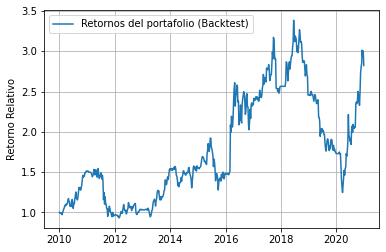

In [23]:
plt.plot(test)
plt.grid()
plt.legend(['Retornos del portafolio (Backtest)'])
plt.ylabel('Retorno Relativo');

In [29]:
y_small = getYPerf(y_) # y is cut down version of y_ with stock returns only

# Create a boolean mask for the backtest year we are interested in
date = pd.to_datetime('2015-01-01 07:00:00')
mask = y_["Date"].between( pd.to_datetime(date) - pd.Timedelta(days=60), pd.to_datetime(date) + pd.Timedelta(days=60) )
#y_[mask] # Checking the mask works
#x[mask]

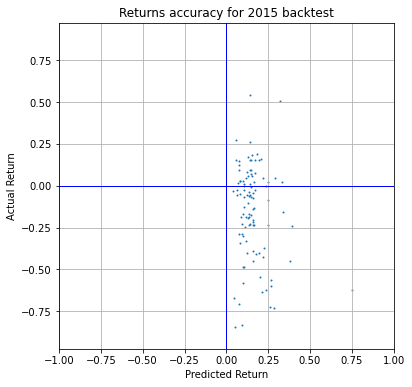

In [30]:
# Load the model pipeline
# can be pl_linear.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p ...
ml_model_pipeline = pickle.load(open("pl_rfregressor.p", "rb" ))
y_pred = ml_model_pipeline.predict(X_test[mask]) # Get stock performance predictions
y_pred = pd.DataFrame(y_pred) # Turn into DataFrame

plt.figure(figsize=(6,6))
# Now output graph.
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
plt.scatter(y_pred[0], y_small[mask]["Perf"], s=1)
# Formatting
plt.grid()
plt.axis('equal')
plt.title('Returns accuracy for {} backtest'.format(date.year))
plt.xlabel('Predicted Return')
plt.ylabel('Actual Return')
plt.axvline(c='blue', lw=1)
plt.axhline(c='blue', lw=1)
plt.savefig('result.png')
plt.axis([-1,1,-1,1]);

In [31]:
# Top stocks picked, and predicted performance.
bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

print("\nTop predicted perf. stocks picked are:")
print(y_small[mask].reset_index(drop=True)[bl]["Ticker"])
print("\nTop stocks predicted performance is:")
print(y_pred[bl])


print("\nActual performance was: ")
print(y_small[mask].reset_index(drop=True)[bl])

# Calc Altman Z score:
Z = 3.25 \
+ 6.51 * X_test[mask].reset_index(drop=True)[bl]['(CA-CL)/TA']\
+ 3.26 * X_test[mask].reset_index(drop=True)[bl]['RE/TA']\
+ 6.72 * X_test[mask].reset_index(drop=True)[bl]['EBIT/TA']\
+ 1.05 * X_test[mask].reset_index(drop=True)[bl]['Book Equity/TL']
print('\nZ scores:\n',Z)


Top predicted perf. stocks picked are:
19     MITK
25     JYNT
33     ZEUS
47     SKYW
70     NVTA
87     MODN
102    SGEN
Name: Ticker, dtype: object

Top stocks predicted performance is:
            0
19   0.321282
25   0.381845
33   0.389647
47   1.106799
70   0.751826
87   0.331292
102  0.339448

Actual performance was: 
    Ticker      Perf
19    MITK  0.506061
25    JYNT -0.449275
33    ZEUS -0.242227
47    SKYW  0.107610
70    NVTA -0.622857
87    MODN  0.019342
102   SGEN -0.158052

Z scores:
 19      6.338317
25      7.899358
33      7.618906
47      5.267632
70     16.181678
87      6.565608
102     1.300461
dtype: float64


In [32]:
# bool list of 7 greatest performance stocks of y_pred 
bl = (y_pred[0] > y_pred.nlargest(8,0).tail(1)[0].values[0])

# See what the performance is of the selection
print("Backtest return is:")
print(y_small[mask]["Perf"].reset_index(drop=True)[bl].values.mean())

Backtest return is:
-0.1199141830805708


In [24]:
d = getYRawData()

Reading historical time series stock data, matrix size is:  (8125701, 11)


In [34]:
# Make X ticks standard, and grab stock prices as close to those points as possible for each stock (To track performance)
date_range = pd.date_range(start=date, periods=52, freq='W')#DatetimeIndex

# 7 greatest performance stocks of y_pred 
ticker_list = y_[mask].reset_index(drop=True)[bl]["Ticker"].values
stockRet = getStockTimeSeries(date_range, y_, ticker_list , mask, daily_stock_prices)

In [35]:
stockRetRel = getPortfolioRelativeTimeSeries(stockRet)

In [36]:
stockRetRel.head()

,MITK,JYNT,ZEUS,SKYW,NVTA,MODN,SGEN,Portfolio
2015-01-04 07:00:00,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000
2015-01-11 07:00:00,0.966361,1.0,1.0,1.0,1.0,1.005484,1.0,0.995978
2015-01-18 07:00:00,0.917431,1.0,1.0,1.0,1.0,1.017367,1.0,0.990686
2015-01-25 07:00:00,0.984709,1.0,1.0,1.0,1.0,1.007313,1.0,0.998860
2015-02-01 07:00:00,1.051988,1.0,1.0,1.0,1.0,0.983547,1.0,1.005076


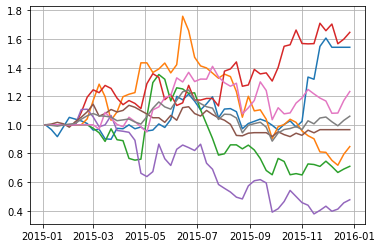

In [37]:
plt.plot(stockRetRel);
plt.grid()

# Now plot backtest with S&P500

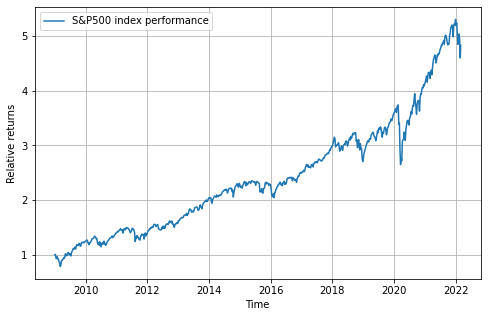

In [25]:
# GSPC.csv taken directly from Yahoo.com is the S&P500.
spy=pd.read_csv("GSPC.csv", index_col='Date', parse_dates=True)
spy['Relative'] = spy["Open"]/spy["Open"][0]

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))
plt.plot(spy['Relative'])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Relative returns')
plt.legend(['S&P500 index performance', 'Linear Regressor Stock Picker'])

In [26]:
start_date = "2010-01-03"
end_date = "2020-12-27"

after_start_date = spy.index >= start_date
before_end_date = spy.index <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = spy.loc[between_two_dates]

In [27]:
filtered_dates.drop(['Relative'], axis=1)

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2010-01-07,53,1136.270020,1149.739990,1131.319946,1145.680054,1145.680054,22802570000
2010-01-14,54,1145.680054,1150.449951,1129.250000,1138.040039,1138.040039,18209320000
2010-01-21,55,1138.680054,1141.579956,1083.109985,1097.500000,1097.500000,27615360000
2010-01-28,56,1096.930054,1104.729980,1071.589966,1097.280029,1097.280029,23977850000
2010-02-04,57,1097.250000,1097.250000,1044.500000,1068.130005,1068.130005,25754120000
...,...,...,...,...,...,...,...
2020-11-26,621,3638.550049,3678.449951,3594.389893,3669.010010,3669.010010,19503130000
2020-12-03,622,3668.280029,3712.389893,3657.169922,3672.820068,3672.820068,24726300000
2020-12-10,623,3659.129883,3711.270020,3633.399902,3701.169922,3701.169922,21997540000


In [28]:
filtered_dates['Relative'] = filtered_dates["Open"]/filtered_dates["Open"][0]

C:\Users\Usuario\AppData\Local\Temp/ipykernel_16312/1391807714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dates['Relative'] = filtered_dates["Open"]/filtered_dates["Open"][0]


In [29]:
filtered_dates

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Relative
Date,,,,,,,,
2010-01-07,53,1136.270020,1149.739990,1131.319946,1145.680054,1145.680054,22802570000,1.000000
2010-01-14,54,1145.680054,1150.449951,1129.250000,1138.040039,1138.040039,18209320000,1.008282
2010-01-21,55,1138.680054,1141.579956,1083.109985,1097.500000,1097.500000,27615360000,1.002121
2010-01-28,56,1096.930054,1104.729980,1071.589966,1097.280029,1097.280029,23977850000,0.965378
2010-02-04,57,1097.250000,1097.250000,1044.500000,1068.130005,1068.130005,25754120000,0.965660
...,...,...,...,...,...,...,...,...
2020-11-26,621,3638.550049,3678.449951,3594.389893,3669.010010,3669.010010,19503130000,3.202188
2020-12-03,622,3668.280029,3712.389893,3657.169922,3672.820068,3672.820068,24726300000,3.228352
2020-12-10,623,3659.129883,3711.270020,3633.399902,3701.169922,3701.169922,21997540000,3.220300


Volatilidad Modelo:  0.5617915786746649
Volatilidad S&P 500:  0.3131362579812779
Retorno modelo:   182.39656141107113 %
Retorno S&P 500:   225.10142518765042 %


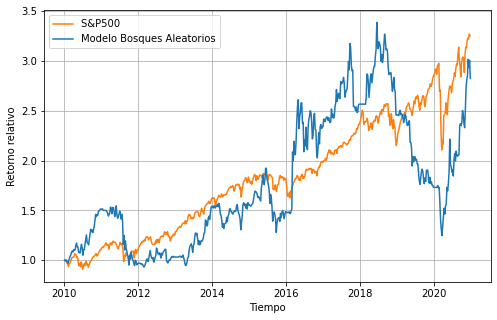

In [34]:
plt.figure(figsize=(8,5))
plt.plot(filtered_dates['Relative'], color='C1')
plt.plot(test["Indexed Performance"], color='C0')
plt.legend(['S&P500 ', modelo])
plt.xlabel('Tiempo')
plt.ylabel('Retorno relativo')
plt.grid()
print('Volatilidad Modelo: ', test['Indexed Performance'].diff().std()*np.sqrt(52))
print('Volatilidad S&P 500: ', filtered_dates['Relative'].diff().std()*np.sqrt(52))
print('Retorno modelo:  ', 100 * (test["Indexed Performance"][-1]-1), '%')
print('Retorno S&P 500:  ', 100 * (filtered_dates["Relative"][-1]-1), '%')

In [33]:
modelo = "Modelo Bosques Aleatorios"

In [54]:
test.to_csv("filtered_dates_BALEATORIOS.csv")

In [55]:
rlinealfil=pd.read_csv("filtered_dates_RLINEAL.csv", index_col=0)
dtreesfil=pd.read_csv("filtered_dates_DTREES.csv", index_col=0)
balefil=pd.read_csv("filtered_dates_BALEATORIOS.csv", index_col=0)
knearfil=pd.read_csv("filtered_dates_KNEAR.csv", index_col=0)

Volatilidad Modelo Regresion Lineal : 0.3989216667848883
Volatilidad Modelo K Vecinos Cercanos : 0.5503734010327676
Volatilidad Modelo Arbol de Decision : 0.40402949312538944
Volatilidad Modelo Bosques Aleaotorios : 0.5617915786746647
Volatilidad S&P 500:  0.3131362579812779
Retorno Modelo Regresion Lineal : 127.41051767078697 %
Retorno Modelo K Vecinos Cercanos : 267.4984024464957 %
Retorno Modelo Arbol de Decision : 118.85787829357261 %
Retorno Modelo Bosques Aleaotorios : 182.39656141107113 %
Retorno S&P 500:   225.10142518765042 %


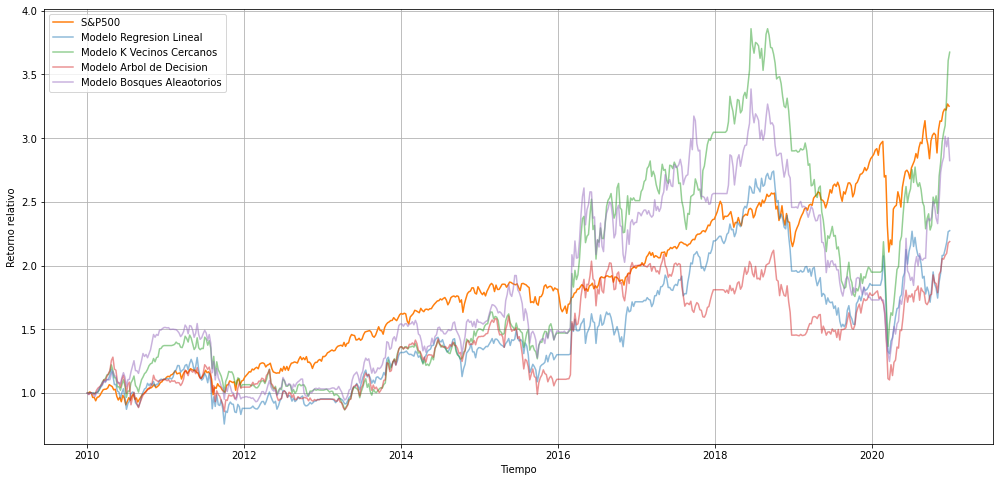

In [125]:
plt.figure(figsize=(17,8))
plt.plot(filtered_dates['Relative'], color='C1')
plt.plot(rlinealfil["Indexed Performance"], color='C0', alpha=0.5)
plt.plot(knearfil["Indexed Performance"], color='C2', alpha=0.5)
plt.plot(dftrees["Indexed Performance"], color='C3', alpha=0.5)
plt.plot(balefil["Indexed Performance"], color='C4', alpha=0.5)

plt.legend(['S&P500 ', modelo1, modelo2, modelo3, modelo4])
plt.xlabel('Tiempo')
plt.ylabel('Retorno relativo')
plt.grid()
print('Volatilidad', modelo1,':', rlinealfil["Indexed Performance"].diff().std()*np.sqrt(52))
print('Volatilidad', modelo2,':', knearfil["Indexed Performance"].diff().std()*np.sqrt(52))
print('Volatilidad', modelo3,':', dftrees["Indexed Performance"].diff().std()*np.sqrt(52))
print('Volatilidad', modelo4,':', balefil["Indexed Performance"].diff().std()*np.sqrt(52))
print('Volatilidad S&P 500: ', filtered_dates['Relative'].diff().std()*np.sqrt(52))
print('Retorno', modelo1, ':',  100 * (rlinealfil["Indexed Performance"][-1]-1), '%')
print('Retorno', modelo2, ':', 100 * (knearfil["Indexed Performance"][-1]-1), '%')
print('Retorno', modelo3, ':', 100 * (dftrees["Indexed Performance"][-1]-1), '%')
print('Retorno', modelo4, ':', 100 * (balefil["Indexed Performance"][-1]-1), '%')
print('Retorno S&P 500:  ', 100 * (filtered_dates["Relative"][-1]-1), '%')

In [114]:
modelo1 = "Modelo Regresion Lineal"
modelo2 = "Modelo K Vecinos Cercanos"
modelo3 = "Modelo Arbol de Decision"
modelo4 = "Modelo Bosques Aleaotorios"

In [86]:
dftrees = pd.DataFrame(data=dtreesfil)
dftrees

,Indexed Performance
2010-01-03,1.000000
2010-01-10,0.988211
2010-01-17,1.005044
2010-01-24,0.996160
2010-01-31,0.996698
...,...
2020-11-29,2.050577
2020-12-06,2.079621
2020-12-13,2.096340
2020-12-20,2.177306


In [92]:
dtreesfil.index = pd.to_datetime(dtreesfil.index)
rlinealfil.index = pd.to_datetime(rlinealfil.index)
balefil.index = pd.to_datetime(balefil.index)
knearfil.index = pd.to_datetime(knearfil.index)
dtreesfil
rlinealfil
balefil
knearfil

,Indexed Performance
2010-01-03,1.000000
2010-01-10,0.996374
2010-01-17,0.999708
2010-01-24,0.998012
2010-01-31,0.995731
...,...
2020-11-29,3.044391
2020-12-06,3.100422
2020-12-13,3.333009
2020-12-20,3.608672


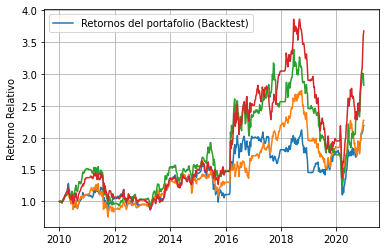

In [93]:
plt.plot(dftrees)
plt.plot(rlinealfil)
plt.plot(balefil)
plt.plot(knearfil)
plt.grid()
plt.legend(['Retornos del portafolio (Backtest)'])
plt.ylabel('Retorno Relativo');